In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

$\alpha^2$

We define a function `man_ExpSquaredKernel(t, A=1.0, l=1.0)` that returns the covariance matrix described by the squared exponential kernel for two arrays of times `t1` and `t2`. (We can also use it as `from george.kernels import ExpSquaredKernel`, where, the *metric* parameter in `ExpSquaredKernel` represents $2.l^2$ (where $l$ is the length scale))

In [2]:
def man_ExpSquaredKernel(t1, t2=None, A=1.0, l=1.0):
    if t2 is None:
        t2 = t1
    T2, T1 = np.meshgrid(t2, t1)
    return A ** 2 * np.exp(-0.5 * (T1-T2)**2 / l**2)

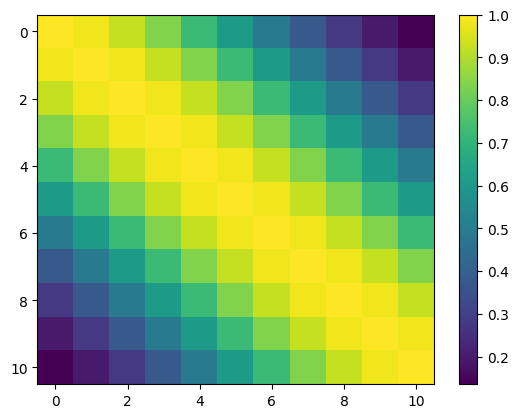

In [14]:
# Visual representation of the Kernel Matrix
t = np.linspace(0,2,11)
S = man_ExpSquaredKernel(t)
plt.imshow(S, interpolation='nearest',aspect='auto')
plt.colorbar();

To draw samples from a multivariate Gaussian given its mean vector `mu` and its covariance matrix `S`, we can use `np.random.multivariate_normal`.

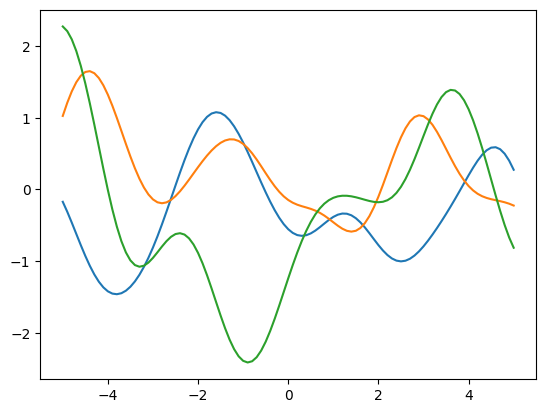

In [3]:
t = np.linspace(-5,5,101)
mu = np.zeros_like(t)
S = man_ExpSquaredKernel(t)
samples = np.random.multivariate_normal(mu, S, 3)
plt.plot(t,samples.T);

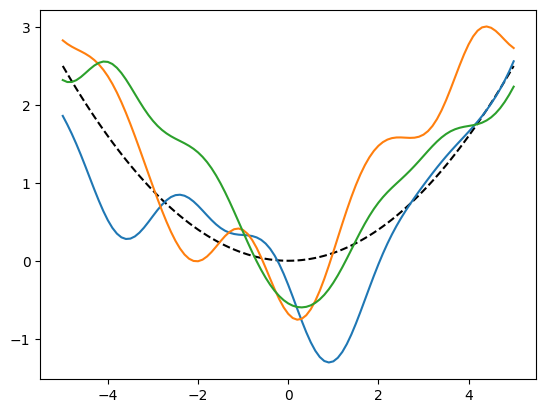

In [4]:
# Introduced a non-trivial mean vector
mu = 0.1 * t**2
plt.plot(t,mu,'k--')
samples = np.random.multivariate_normal(mu, S, 3)
plt.plot(t,samples.T);

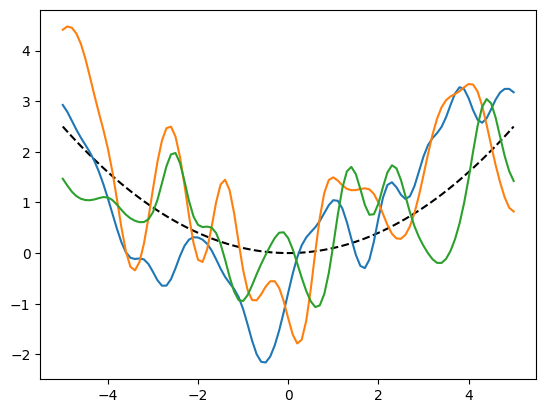

In [10]:
# Varying the hyperparameters
mu = 0.1 * t**2
S = man_ExpSquaredKernel(t, l = 0.4)
samples = np.random.multivariate_normal(mu, S, 3)
plt.plot(t, mu, 'k--')
plt.plot(t, samples.T);

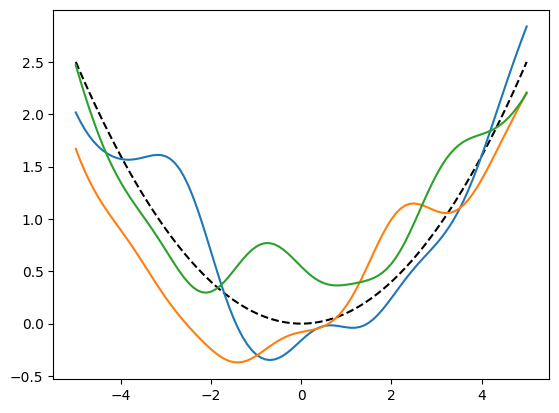

In [9]:
mu = 0.1 * t**2
S = man_ExpSquaredKernel(t, A = 0.4)
samples = np.random.multivariate_normal(mu, S, 3)
plt.plot(t, mu, 'k--')
plt.plot(t, samples.T);

### Conditioning GP on some prior data

We showcase this on an exemplar train_data randomly generated

Next, we define a function `compute_gp` that evaluates the mean vector `mu` and covariance matrix `S` of the GP evaluated at training points `t_test` given some data (`t_train`, `y_train`).

In [7]:
def compute_gp(t_train, y_train, t_test, kernel = man_ExpSquaredKernel, **kwargs):
    # Compute the required matrices
    Stt = kernel(t_train, **kwargs)
    Spp = kernel(t_test, **kwargs)
    Spt = kernel(t_test, t_train, **kwargs)

    # Compute the mean and covariance of the GP
    mu = np.dot(Spt, np.linalg.solve(Stt, y_train))
    S = Spp - np.dot(Spt, np.linalg.solve(Stt, Spt.T))

    return mu, S

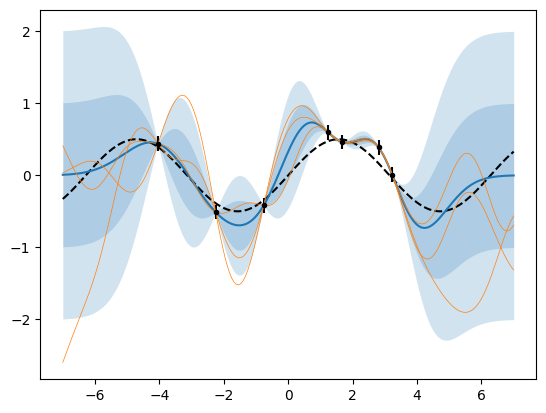

In [8]:
t_train = np.random.uniform(-5,5,7)
wn = 0.1
y_train = 0.5 * np.sin(t_train) + np.random.normal(0, 1, len(t_train)) * wn
plt.errorbar(t_train, y_train, yerr = wn, fmt='k.', capsize=0)
t_test = np.linspace(-7, 7, 201)
y_true = 0.5 * np.sin(t_test)
plt.plot(t_test, y_true, 'k--')
gp_mu, gp_S = compute_gp(t_train, y_train, t_test)
sig = np.sqrt(gp_S.diagonal())
plt.plot(t_test, gp_mu, color="C0")
plt.fill_between(t_test, gp_mu - sig, gp_mu + sig, color="C0", alpha=0.2,lw=0);
plt.fill_between(t_test, gp_mu - 2 * sig, gp_mu + 2 * sig, color="C0", alpha=0.2,lw=0);
samples = np.random.multivariate_normal(gp_mu, gp_S,3)
plt.plot(t_test, samples.T, color="C1", lw=0.5);

Next, we define the negative log likelihood (`nll`) function of the GP

In [11]:
def nll_gp(p, t, y, sigma):
    A, l = np.exp(p)
    npts = len(t)
    K = man_ExpSquaredKernel(t, A = A, l=l) + sigma ** 2 * np.eye(npts)
    nll = 0.5 * np.dot(y.T, np.linalg.solve(K, y))
    nll += 0.5 * np.linalg.slogdet(K)[1]
    nll += 0.5 * npts * np.log(2 * np.pi)
    return nll

[1. 1.] 5.380863128783793
[0.42382771 0.77467689] 3.0736682782877924


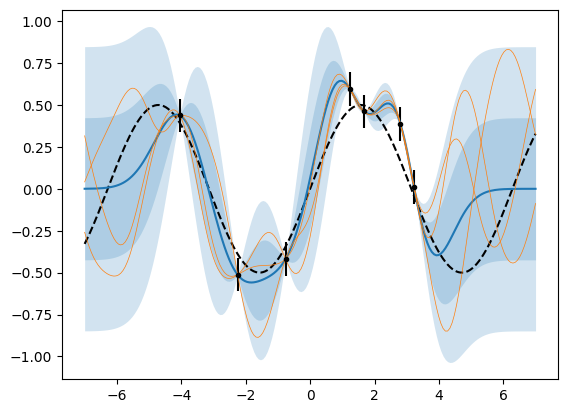

In [13]:
from scipy.optimize import minimize 
p0 = np.array([0.0, 0.0])

print(np.exp(p0),nll_gp(p0,t_train,y_train,wn))
res = minimize(nll_gp, p0, args = (t_train, y_train, wn))
ml_par = res.x
print(np.exp(ml_par), res.fun)

plt.errorbar(t_train, y_train, yerr = wn, fmt='k.', capsize=0)
plt.plot(t_test, y_true, 'k--')
gp_mu, gp_S = compute_gp(t_train, y_train, t_test, A = np.exp(ml_par[0]), l = np.exp(ml_par[1]))
sig = np.sqrt(gp_S.diagonal())
plt.plot(t_test, gp_mu, color="C0")
plt.fill_between(t_test, gp_mu - sig, gp_mu + sig, color="C0", alpha=0.2,lw=0);
plt.fill_between(t_test, gp_mu - 2 * sig, gp_mu + 2 * sig, color="C0", alpha=0.2,lw=0);
samples = np.random.multivariate_normal(gp_mu, gp_S,3)
plt.plot(t_test, samples.T, color="C1", lw=0.5);

# Simulating a noisy light curve with Sinusoidal and Gaussian waves

In [4]:
# Imports and seed
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Exponentiated Squared (RBF) Kernel
def ExpSquaredKernel(t1, t2=None, A=1.0, l=1.0):
    if t2 is None:
        t2 = t1
    T2, T1 = np.meshgrid(t2, t1)
    return A**2 * np.exp(-0.5 * (T1 - T2)**2 / l**2)

## Simulating a Sinusoidal Signal (e.g., stellar pulsation)

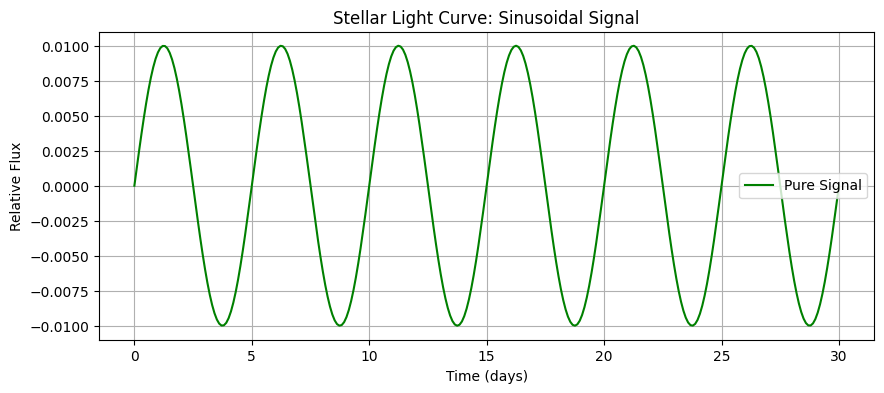

In [3]:
# Time array (e.g., 30 days sampled every 0.1 days)
t = np.linspace(0, 30, 300)

period = 5  # days
amplitude = 0.01  # relative flux
signal = amplitude * np.sin(2 * np.pi * t / period)

plt.figure(figsize=(10, 4))
plt.plot(t, signal, label="Pure Signal", color='green')
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("Stellar Light Curve: Sinusoidal Signal")
plt.legend()
plt.grid(True)
plt.show()


## Simulating a GP Noise

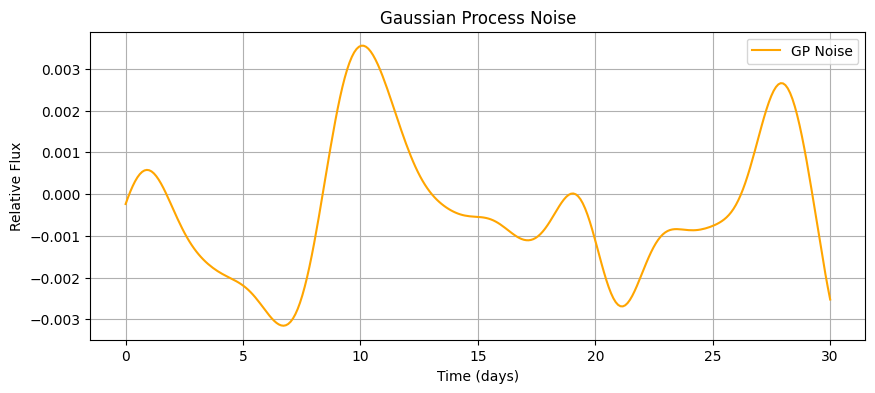

In [5]:
# Parameters: amplitude A and length scale l of the GP kernel
A_gp = 0.002  # smaller than signal amplitude
l_gp = 1.5    # correlation length scale

# Covariance matrix
cov = ExpSquaredKernel(t, A=A_gp, l=l_gp)

# Sample from the multivariate normal
noise = np.random.multivariate_normal(mean=np.zeros(len(t)), cov=cov)

plt.figure(figsize=(10, 4))
plt.plot(t, noise, label="GP Noise", color='orange')
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("Gaussian Process Noise")
plt.legend()
plt.grid(True)
plt.show()

## Combining the two curves to simulate a Noisy Stellar Light Curve

We also add a `white_noise` to further simulate real signal capture. Here, the White Noise follows a Normal Distribution with variance $\sigma ^2$. Mathematically speaking,
`white_noise` ~ $N(0, \sigma ^2)$

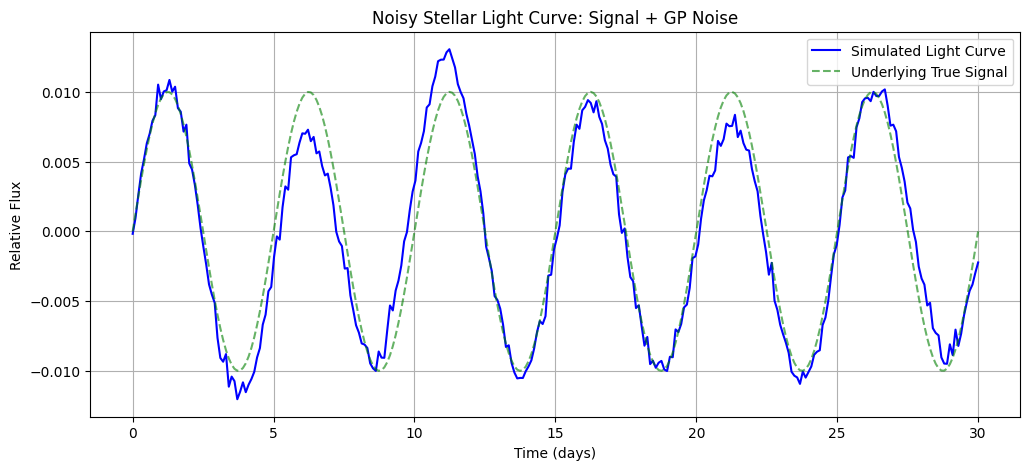

In [11]:
sigma = 0.0005
white_noise = np.random.normal(0, sigma, size=t.shape)

lightcurve = signal + noise + white_noise

plt.figure(figsize=(12, 5))
plt.plot(t, lightcurve, label="Simulated Light Curve", color='blue')
plt.plot(t, signal, label="Underlying True Signal", color='green', alpha=0.6, linestyle='--')
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("Noisy Stellar Light Curve: Signal + GP Noise")
plt.legend()
plt.grid(True)
plt.show()
